In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install matplotlib pandas numpy scipy seaborn mne
!pip install beautifulsoup4 requests wget
!pip install h5py tables kaggle
!pip install wfdb pyEDFlib

     |████████████████████████████████| 6.8MB 11.9MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=a53d43707261c42982c55d7302c4dea35deaf140dd6d17c2c60e9d99c6f86e17
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 122kB 11.9MB/s 
     |████████████████████████████████| 1.2MB 19.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 54.4MB/s 
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.19-cp36-cp36m-linux_x86_64.whl size=925713 sha256=0c14c086cb7fae3c8b9375defb2dfe5a37c7165f5a9a0bda3fa5b5ec9f6833dd
  Stored in directory: /root/.cache/pip/wheels/1f/b7/24/a565e4f7471617165f1b040651b52d87ad1885aaf32e02d4f9
Successfully built pyEDFlib
  Created wheel for wfdb: filename=wfdb-3.1.1-cp36-none-any.whl size=1178

Lets create a function to list all the files/directories it finds in a location and save them to a list.

In [ ]:
import glob            # for file locations
import pprint          # for pretty printing
import re

pp = pprint.PrettyPrinter()

def file_list(folder_path, output=False):
    # create an empty list
    file_list = []
    # for file name in the folder path...
    for filename in glob.glob(folder_path):
        # ... append it to the list
        file_list.append(filename)
        
    # sort alphabetically
    file_list.sort()
    
    # Output
    if output:
        print(str(len(file_list)) + " files found")
        pp.pprint(file_list)
    
    return file_list

## Data Information
The dataset is stored on Physionet which has some helpful tools to access the data. We are going to use one such package (wfdb) to get a list of the records in the dataset.

In [ ]:
import wfdb 

dbs = wfdb.get_dbs()

records_list = wfdb.io.get_record_list('chbmit', records='all')
records_list[:5]

['chb01/chb01_01.edf',
 'chb01/chb01_02.edf',
 'chb01/chb01_03.edf',
 'chb01/chb01_04.edf',
 'chb01/chb01_05.edf']

Using the above, lets get a list of the unique directory names

In [ ]:
part_codes = sorted(list(set([record.split('/')[0] for record in records_list])))
part_codes

['chb01',
 'chb02',
 'chb03',
 'chb04',
 'chb05',
 'chb06',
 'chb07',
 'chb08',
 'chb09',
 'chb10',
 'chb11',
 'chb12',
 'chb13',
 'chb14',
 'chb15',
 'chb16',
 'chb17',
 'chb18',
 'chb19',
 'chb20',
 'chb21',
 'chb22',
 'chb23',
 'chb24']

Each patient has an information file associate with it. Lets load one in and have a look at how it looks before we parse it into something more useful.

In [ ]:
import os
from urllib.request import urlretrieve

def get_content(part_code):
  url = "https://physionet.org/physiobank/database/chbmit/"+part_code+'/'+part_code+'-summary.txt'
  filename = "./chbmit.txt"

  urlretrieve(url,filename)

  # read the file into a list
  with open(filename, encoding='UTF-8') as f:
      # read all the document into a list of strings (each line a new string)
      content = f.readlines()
      os.remove(filename)

  return content

get_content(part_codes[0])

['Data Sampling Rate: 256 Hz\n',
 '*************************\n',
 '\n',
 'Channels in EDF Files:\n',
 '**********************\n',
 'Channel 1: FP1-F7\n',
 'Channel 2: F7-T7\n',
 'Channel 3: T7-P7\n',
 'Channel 4: P7-O1\n',
 'Channel 5: FP1-F3\n',
 'Channel 6: F3-C3\n',
 'Channel 7: C3-P3\n',
 'Channel 8: P3-O1\n',
 'Channel 9: FP2-F4\n',
 'Channel 10: F4-C4\n',
 'Channel 11: C4-P4\n',
 'Channel 12: P4-O2\n',
 'Channel 13: FP2-F8\n',
 'Channel 14: F8-T8\n',
 'Channel 15: T8-P8\n',
 'Channel 16: P8-O2\n',
 'Channel 17: FZ-CZ\n',
 'Channel 18: CZ-PZ\n',
 'Channel 19: P7-T7\n',
 'Channel 20: T7-FT9\n',
 'Channel 21: FT9-FT10\n',
 'Channel 22: FT10-T8\n',
 'Channel 23: T8-P8\n',
 '\n',
 'File Name: chb01_01.edf\n',
 'File Start Time: 11:42:54\n',
 'File End Time: 12:42:54\n',
 'Number of Seizures in File: 0\n',
 '\n',
 'File Name: chb01_02.edf\n',
 'File Start Time: 12:42:57\n',
 'File End Time: 13:42:57\n',
 'Number of Seizures in File: 0\n',
 '\n',
 'File Name: chb01_03.edf\n',
 'File Sta

Taking the above, the below function below just parses this file up into a Python dictionary format.

In [ ]:
import re
part_info_dict = {}

def info_dict(content):
  
  line_nos=len(content)
  line_no=1

  channels = []
  file_name = []
  file_info_dict={}

  for line in content:

    # if there is Channel in the line...
    if re.findall('Channel \d+', line):
      # split the line into channel number and channel reference
      channel = line.split(': ')
      # get the channel reference and remove any new lines
      channel = channel[-1].replace("\n", "")
      # put into the channel list
      channels.append(channel)

    # if the line is the file name
    elif re.findall('File Name', line):
      # if there is already a file_name
      if file_name:
        # flush the current file info to it
        part_info_dict[file_name] = file_info_dict

      # get the file name
      file_name = re.findall('\w+\d+_\d+|\w+\d+\w+_\d+', line)[0]

      file_info_dict = {}
      # put the channel list in the file info dict and remove duplicates
      file_info_dict['Channels'] = list(set(channels))
      # reset the rest of the options
      file_info_dict['Start Time'] = ''
      file_info_dict['End Time'] = ''
      file_info_dict['Seizures Window'] = []

    # if the line is about the file start time
    elif re.findall('File Start Time', line):
      # get the start time
      file_info_dict['Start Time'] = re.findall('\d+:\d+:\d+', line)[0]

    # if the line is about the file end time
    elif re.findall('File End Time', line):
      # get the start time
      file_info_dict['End Time'] = re.findall('\d+:\d+:\d+', line)[0]

    elif re.findall('Seizure Start Time|Seizure End Time|Seizure \d+ Start Time|Seizure \d+ End Time', line):
      file_info_dict['Seizures Window'].append(int(re.findall('\d+', line)[-1]))

    # if last line in the list...
    if line_no == line_nos:
      # flush the file info to it
      part_info_dict[file_name] = file_info_dict

    line_no+=1
    
        
for part_code in part_codes:
  content = get_content(part_code)
  info_dict(content)


display(part_info_dict['chb23_06'])

{'Channels': ['C3-P3',
  'T7-P7',
  'FP2-F4',
  'F8-T8',
  'T8-P8',
  'P8-O2',
  'CZ-PZ',
  'F3-C3',
  'P4-O2',
  'T7-FT9',
  'FT9-FT10',
  'P7-O1',
  'F4-C4',
  'FT10-T8',
  'P3-O1',
  'FP2-F8',
  'FP1-F3',
  'P7-T7',
  'C4-P4',
  'F7-T7',
  'FP1-F7',
  'FZ-CZ'],
 'End Time': '11:02:43',
 'Seizures Window': [3962, 4075],
 'Start Time': '08:57:57'}

As can be seen below there is a common set of channels found in ALL patients, but there are also some channels only found in individual patients. This is because sometimes channels were swapped during recording for others. 

In [ ]:
import pandas as pd     # dataframes
import re

all_channels = []

for key in part_info_dict.keys():
    all_channels.extend(part_info_dict[key]['Channels'])
    
# turn the list into a pandas series
all_channels = pd.Series(all_channels)

# count how many times the channels appear in each participant
channel_counts = all_channels.value_counts()
channel_counts

FP1-F3     675
FZ-CZ      675
P3-O1      675
F7-T7      675
F3-C3      675
          ... 
C6          13
P4          13
CP4         13
P3          13
LOC-ROC     11
Length: 87, dtype: int64

We only keep the channels found in all the patients.

In [ ]:
threshold = len(part_info_dict.keys())
channel_keeps = list(channel_counts[channel_counts >= threshold].index)
channel_keeps

['FP1-F3',
 'FZ-CZ',
 'P3-O1',
 'F7-T7',
 'F3-C3',
 'F8-T8',
 'T7-P7',
 'C3-P3',
 'CZ-PZ',
 'P4-O2',
 'C4-P4',
 'F4-C4',
 'FP2-F8',
 'P8-O2',
 'T8-P8',
 'FP1-F7',
 'FP2-F4',
 'P7-O1']

## Load Data
Lets now load in some example data. First lets choose a file.

In [ ]:
EXAMPLE_FILE = records_list[2]
EXAMPLE_ID = EXAMPLE_FILE.split('/')[1].split('.')[0]
EXAMPLE_ID

'chb01_03'

# Download the data and then load it into a pandas dataframe


In [ ]:
import pandas as pd
import numpy as np
import pyedflib

def data_load(file, selected_channels=[]):

  try: 
    url = "https://physionet.org/physiobank/database/chbmit/"+file
    filename = "./chbmit.edf"

    urlretrieve(url,filename)
    # use the reader to get an EdfReader file
    f = pyedflib.EdfReader(filename)
    os.remove(filename)
    
    # get a list of the EEG channels
    if len(selected_channels) == 0:
      selected_channels = f.getSignalLabels()

    # get the names of the signals
    channel_names = f.getSignalLabels()
    # get the sampling frequencies of each signal
    channel_freq = f.getSampleFrequencies()

    # make an empty file of 0's
    sigbufs = np.zeros((f.getNSamples()[0],len(selected_channels)))
    # for each of the channels in the selected channels
    for i, channel in enumerate(selected_channels):
      # add the channel data into the array
      sigbufs[:, i] = f.readSignal(channel_names.index(channel))
    
    # turn to a pandas df and save a little space
    df = pd.DataFrame(sigbufs, columns = selected_channels).astype('float32')
    
    # get equally increasing numbers upto the length of the data depending
    # on the length of the data divided by the sampling frequency
    index_increase = np.linspace(0,
                                 len(df)/channel_freq[0],
                                 len(df), endpoint=False)

    # round these to the lowest nearest decimal to get the seconds
    seconds = np.floor(index_increase).astype('uint16')

    # make a column the timestamp
    df['Time'] = seconds

    # make the time stamp the index
    df = df.set_index('Time')

    # name the columns as channel
    df.columns.name = 'Channel'

    return df, channel_freq[0]

  except:
    OSError
    return pd.DataFrame(), None


# Create MNE object

In [ ]:
import mne

def mne_object(data, freq, events = None):
  # create an mne info file with meta data about the EEG
  info = mne.create_info(ch_names=list(data.columns), 
                         sfreq=freq, 
                         ch_types=['eeg']*data.shape[-1]);
  
  # data needs to be in volts rather than in microvolts
  data = data.apply(lambda x: x*1e-6);
  # transpose the data
  data_T = data.transpose();
  
  # create raw mne object
  raw = mne.io.RawArray(data_T, info);

  if events:
    start_times = np.array(events[::2])
    end_times = np.array(events[1::2])

  return raw

In [ ]:
records_list[346]

'chb12/chb12_32.edf'

# Generate and store the Stacked Spectrograms

Creating RawArray with float64 data, n_channels=18, n_times=921600
    Range : 0 ... 921599 =      0.000 ...  3599.996 secs
Ready.


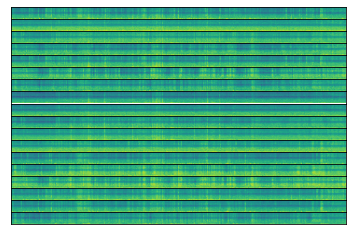

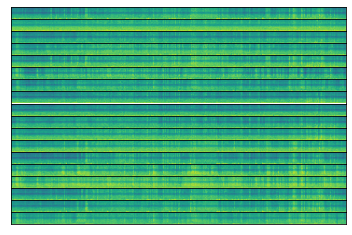

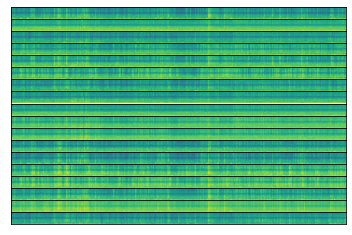

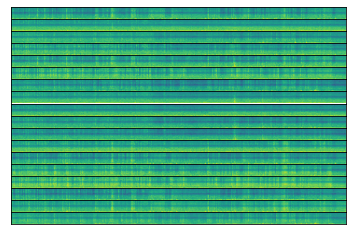

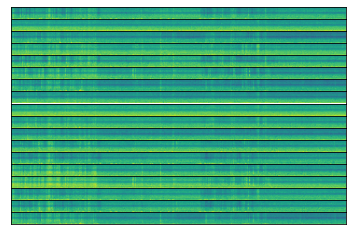

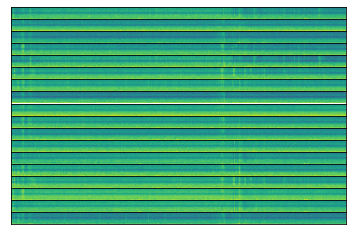

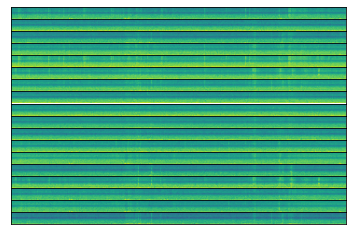

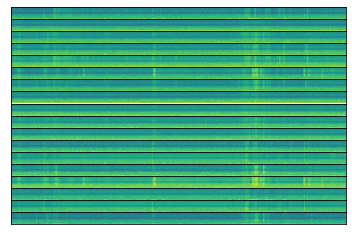

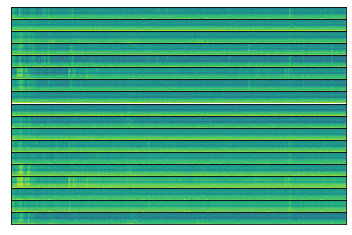

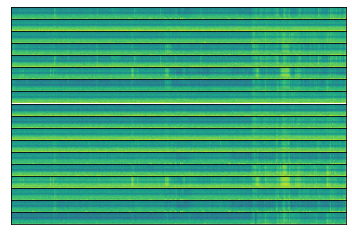

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime

subjects_to_be_used = {'chb05', 'chb08', 'chb11', 'chb12', 'chb13', 'chb14', 'chb15', 'chb23'}

for k in range(346,len(records_list)):
    try:
        CURRENT_FILE = records_list[k]
        CURRENT_ID = CURRENT_FILE.split('/')[1].split('.')[0]
        if CURRENT_ID[:5] not in subjects_to_be_used:
            continue

        try:
            if part_info_dict[CURRENT_ID]['Start Time'][:2] == '24' or part_info_dict[CURRENT_ID]['End Time'][:2] == '24':
                continue
        except:
            continue

        raw_data, freq = data_load(CURRENT_FILE, channel_keeps);

        mne_data = mne_object(raw_data, freq, part_info_dict[CURRENT_ID]['Seizures Window']);

        seizure_dir = '/content/drive/My Drive/DM Course Project/New Spectrogram/seizure/'
        non_seizure_dir = '/content/drive/My Drive/DM Course Project/New Spectrogram/non-seizure/'

        window = 180
        start_time = 0

        start = datetime.strptime(part_info_dict[CURRENT_ID]['Start Time'], '%H:%M:%S')
        end = datetime.strptime(part_info_dict[CURRENT_ID]['End Time'], '%H:%M:%S')

        diff = (end - start).seconds

        i = 0
        while start_time + window <= diff:
            fig = plt.figure()
            idx = 1
            for channelNM in channel_keeps:
                ax = fig.add_subplot(18, 1, idx)
                plt.xticks([])

                plt.yticks([])
                idx += 1
                freq = mne_data[channelNM][0][0][start_time * 256:(start_time + window) * 256]
                ax.specgram(freq, Fs=256)
            plt.subplots_adjust(wspace=0, hspace=0)
            fig.savefig(f'{non_seizure_dir}{CURRENT_ID}_{i}.png', bbox_inches = 'tight')
            plt.show()
            plt.close('all')
            i += 1
            start_time += int(window - window * 0.3)

        seizures = part_info_dict[CURRENT_ID]['Seizures Window']

        j = 0
        i = 0
        while j < len(seizures):
            seizure_start_time = seizures[j]
            seizure_end_time = seizures[j + 1]
            j += 2

            start_time = seizure_start_time

            while start_time + 3 < seizure_end_time:
                fig = plt.figure()
                idx = 1
                for channelNM in channel_keeps:
                    ax = fig.add_subplot(18, 1, idx)
                    plt.xticks([])
                    plt.yticks([])
                    idx += 1
                    freq = mne_data[channelNM][0][0][start_time * 256:(start_time + window) * 256]
                    ax.specgram(freq, Fs=256)
                plt.subplots_adjust(wspace=0, hspace=0)
                fig.savefig(f'{seizure_dir}{CURRENT_ID}_{i}.png', bbox_inches = 'tight')
                plt.show()
                plt.close('all')
                i += 1
                start_time += 1
    except:
        continue

In [ ]:
import os

def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

seizure_dir = '/content/drive/My Drive/DM Course Project/New Spectrogram/seizure/'
non_seizure_dir = '/content/drive/My Drive/DM Course Project/New Spectrogram/non-seizure/'

# print(get_size(seizure_dir), 'bytes')
# print(get_size(non_seizure_dir), 'bytes')

print("No. of non-seizure plots:", len(os.listdir(non_seizure_dir)))
print("No. of seizure plots:", len(os.listdir(seizure_dir)))

No. of non-seizure plots: 6473
No. of seizure plots: 5618


In [ ]:
import os

def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

seizure_dir = '/content/drive/My Drive/DM Course Project/New New Spectrogram/seizure/'
non_seizure_dir = '/content/drive/My Drive/DM Course Project/New New Spectrogram/non-seizure/'

# print(get_size(seizure_dir), 'bytes')
# print(get_size(non_seizure_dir), 'bytes')

print("No. of non-seizure plots:", len(os.listdir(non_seizure_dir)))
print("No. of seizure plots:", len(os.listdir(seizure_dir)))

In [ ]:
import os

def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

seizure_dir = '/content/drive/My Drive/DM Course Project/C2 Submission/Figures/Plot images/seizure/'
non_seizure_dir = '/content/drive/My Drive/DM Course Project/C2 Submission/Figures/Plot images/non-seizure/'

# print(get_size(seizure_dir), 'bytes')
# print(get_size(non_seizure_dir), 'bytes')

print("No. of non-seizure plots:", len(os.listdir(non_seizure_dir)))
print("No. of seizure plots:", len(os.listdir(seizure_dir)))